In [1]:
import os 
import matplotlib 
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import pickle

In [61]:
#Load the pickle files
import pickle 
with open('day9results_may10_mid.pkl', 'rb') as f:
    day9results = pickle.load(f)

# Save day7results to a pickle file
with open('day7results.pkl', 'rb') as f:
    day7results = pickle.load(f)

In [62]:
day7results[list(day7results.keys())[0]]

,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.721026,0.564103,0.833333,0.660256,0.708333,0.583333,0.812197,0.649485,...,0.160256,0.25641,0.179487,0.626068,0.084402,0.207265,0.082265,7_1,0.0,1.000000
1,Control,1,0.721026,0.564103,0.833333,0.660256,0.708333,0.583333,0.812197,0.649485,...,0.160256,0.25641,0.179487,0.626068,0.084402,0.207265,0.082265,7_10,0.0,0.051282
2,Control,1,0.721026,0.564103,0.833333,0.660256,0.708333,0.583333,0.812197,0.649485,...,0.160256,0.25641,0.179487,0.626068,0.084402,0.207265,0.082265,7_11,1.0,1.000000
3,Control,1,0.721026,0.564103,0.833333,0.660256,0.708333,0.583333,0.812197,0.649485,...,0.160256,0.25641,0.179487,0.626068,0.084402,0.207265,0.082265,7_12,0.0,1.000000
4,Control,1,0.721026,0.564103,0.833333,0.660256,0.708333,0.583333,0.812197,0.649485,...,0.160256,0.25641,0.179487,0.626068,0.084402,0.207265,0.082265,7_2,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.778462,0.250000,0.855769,1.000000,0.791667,0.250000,0.859922,0.400000,...,0.000000,0.75000,0.000000,0.708333,0.060897,0.147436,0.083333,7_5,0.0,1.000000
8,Clonidine,F4,0.778462,0.250000,0.855769,1.000000,0.791667,0.250000,0.859922,0.400000,...,0.000000,0.75000,0.000000,0.708333,0.060897,0.147436,0.083333,7_6,0.0,1.000000
9,Clonidine,F4,0.778462,0.250000,0.855769,1.000000,0.791667,0.250000,0.859922,0.400000,...,0.000000,0.75000,0.000000,0.708333,0.060897,0.147436,0.083333,7_7,1.0,1.000000
10,Clonidine,F4,0.778462,0.250000,0.855769,1.000000,0.791667,0.250000,0.859922,0.400000,...,0.000000,0.75000,0.000000,0.708333,0.060897,0.147436,0.083333,7_8,0.0,1.000000


In [82]:
#fn_out_d9 = './decoder_day9_results.csv'
#fn_out_d7 = './decoder_day7_results.csv'

#results_d9 = pd.read_csv(fn_out_d9).drop(columns = 'Unnamed: 0')
#results_d7 = pd.read_csv(fn_out_d7).drop(columns = 'Unnamed: 0')
import numpy as np

def present_results(results_d7, results_d9, title = None):
    results = pd.concat([results_d7, results_d9])
    results['Session'] = results['Session_trial'].str.split('_').str[0]
    results['Pred_reward_trial'] = (results['Prop_pred_reward_trial'] > 0.5).astype(float)

    prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
    prediction_counts['Previously_rewarded'] = 36-prediction_counts['Reward']

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2,2, figsize = (10, 10), sharey = True)
    if title:
        fig.suptitle(f'Time points: {title}')
    for idx, session in enumerate(['7', '9']):
        axes[0,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Pred_reward_trial,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[0,idx].set_xlabel('treatment')
        axes[0,idx].set_ylabel('Predicted reward trials (/36)')
        axes[0,idx].set_title(f'Day {session}')

    for idx, session in enumerate(['7', '9']):
        axes[1,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Previously_rewarded,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[1,idx].set_xlabel('treatment')
        axes[1,idx].set_ylabel('Previously rewarded trials (/36)')

    return prediction_counts

def compute_stats(prediction_counts, title = ''):
    pairs = [('Clonidine', 'Control'),('Clonidine', 'Idazoxan'),('Control', 'Idazoxan')]
    days = ['7', '9']
    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Pred_reward_trial'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Pred_reward_trial'].values[0]
            if (row1_val == row2_val == 36) or (row1_val == row2_val == 36):
                pval = -1
            else:
                c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
                pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_pred_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Previously_rewarded'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Previously_rewarded'].values[0]
            c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
            pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_reward_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    print(title)
    print('Test reward prediction comparisons')
    print(test_results_pred_trials)
    print(title)
    print('Test rewarded trials comparisons')
    print(test_results_reward_trials)
    return test_results_pred_trials, test_results_reward_trials

/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()


(1, 40)
                              7         9
(Clonidine, Control)   0.267002  0.751830
(Clonidine, Idazoxan)  0.081659  0.016997
(Control, Idazoxan)    0.733271  0.063682
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(41, 80)
                              7         9
(Clonidine, Control)   0.000236  0.154044
(Clonidine, Idazoxan)  0.010733  0.060793
(Control, Idazoxan)    0.238185  1.000000
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(81, 120)
                              7         9
(Clonidine, Control)   0.014243  0.047221
(Clonidine, Idazoxan)  0.004427  0.000504
(Control, Idazoxan)    1.000000  0.122713
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Contro

/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list inst

(201, 240)
                              7         9
(Clonidine, Control)   0.013308  0.119782
(Clonidine, Idazoxan)  0.024449  0.043170
(Control, Idazoxan)    1.000000  0.811070
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(1, 80)
                              7         9
(Clonidine, Control)   0.066016  0.008665
(Clonidine, Idazoxan)  0.008778  0.008665
(Control, Idazoxan)    0.606905 -1.000000
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(81, 160)
                              7         9
(Clonidine, Control)   0.049365  0.056759
(Clonidine, Idazoxan)  0.049365  0.000236
(Control, Idazoxan)    1.000000  0.063682
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Cont

/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/1986499176.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list inst

(201, 280)
                              7         9
(Clonidine, Control)   0.038056  1.000000
(Clonidine, Idazoxan)  0.000048  0.153276
(Control, Idazoxan)    0.058464  0.094264
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475


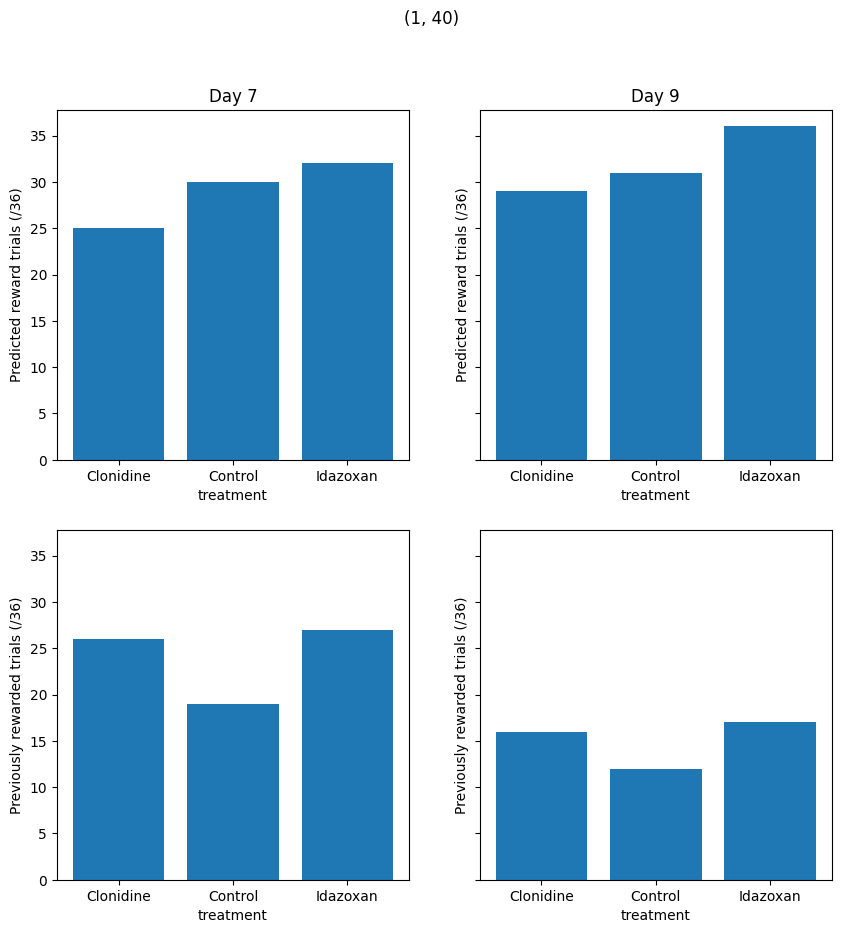

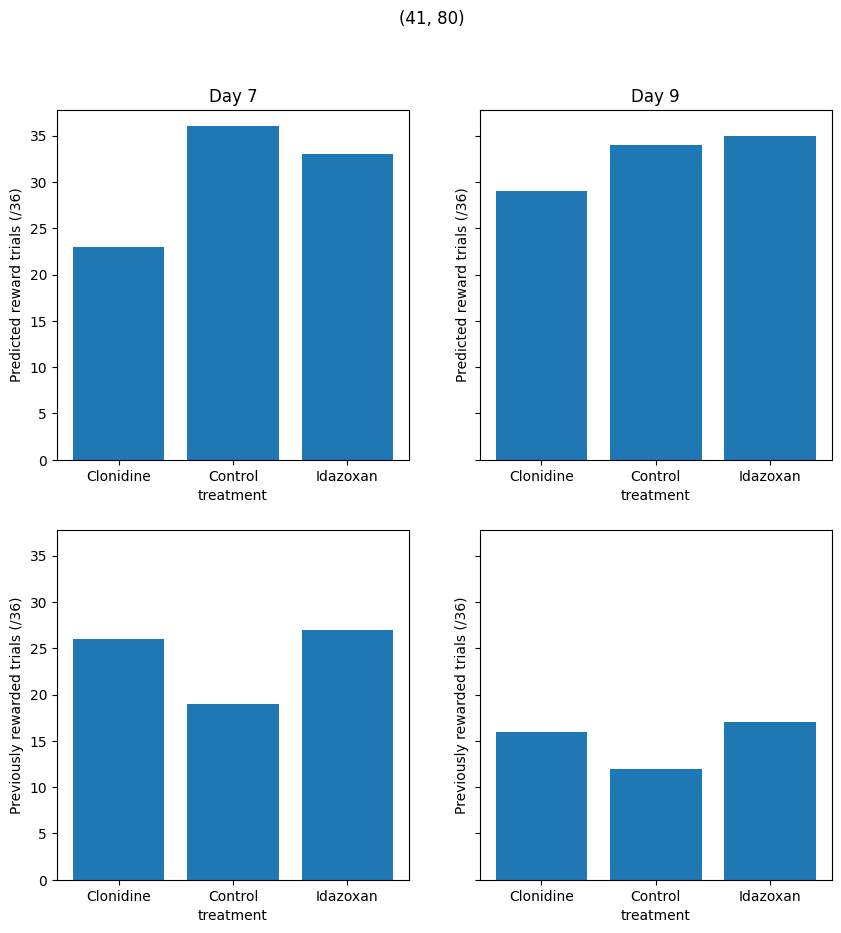

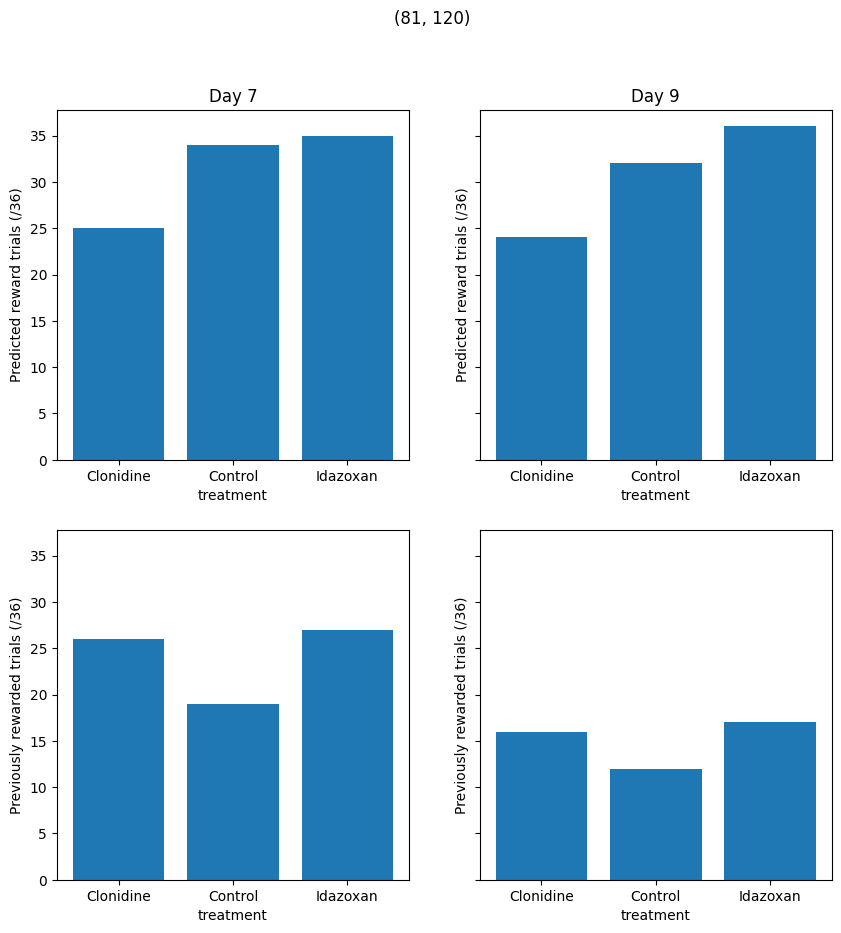

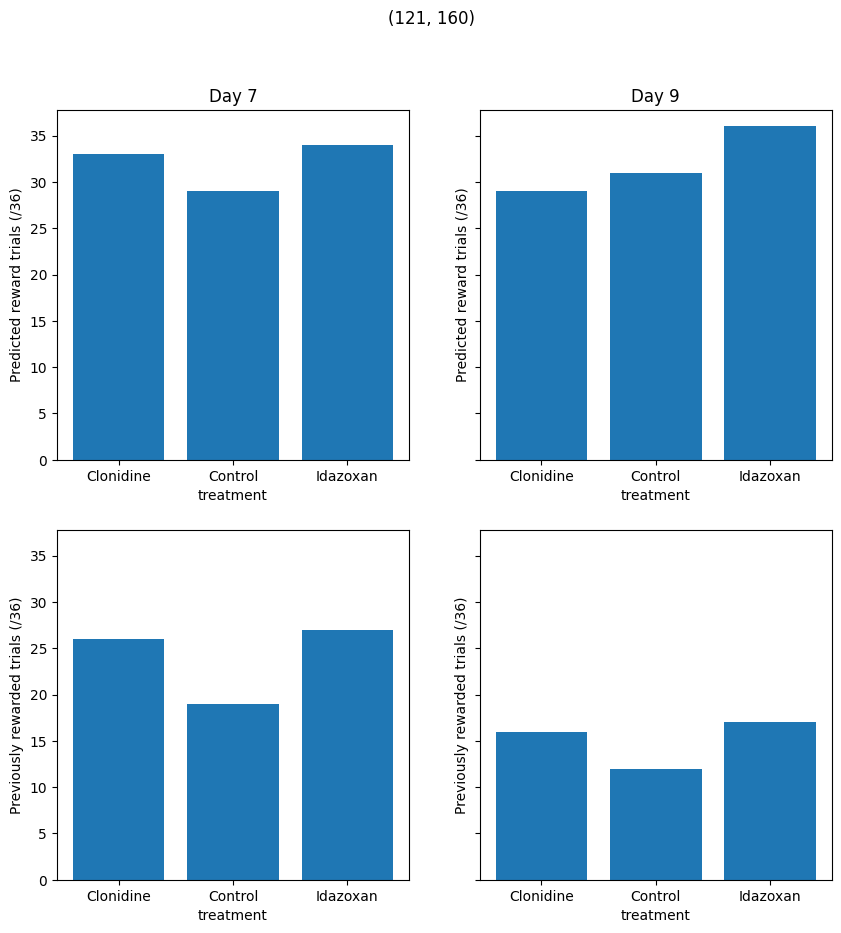

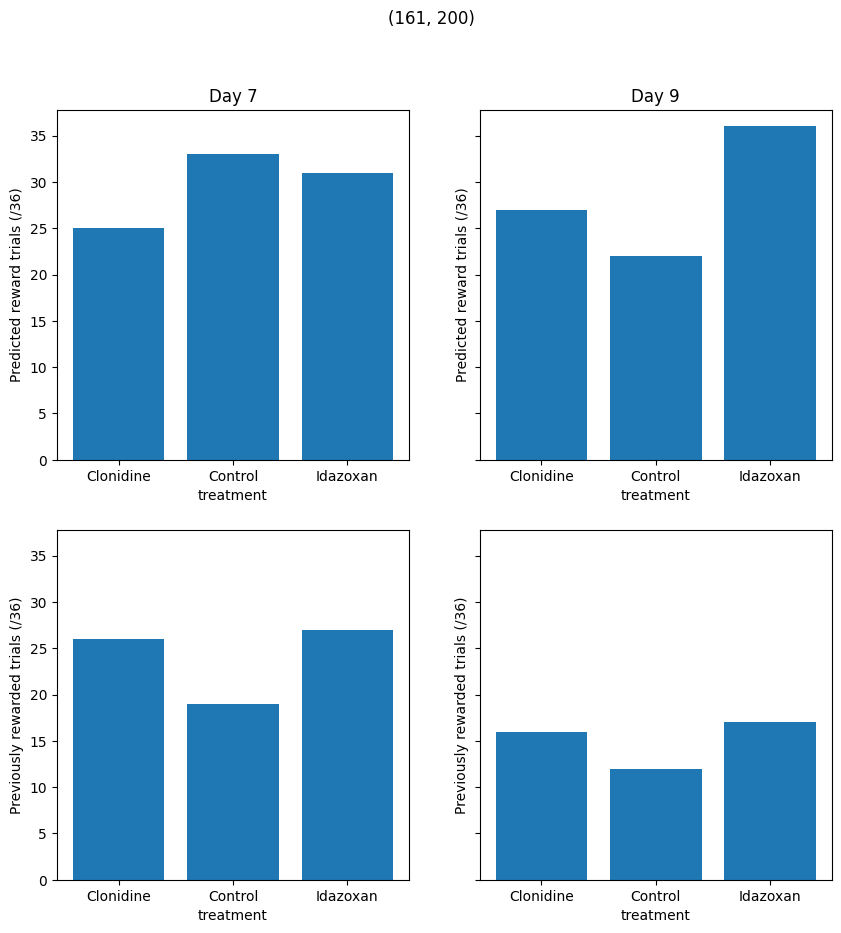

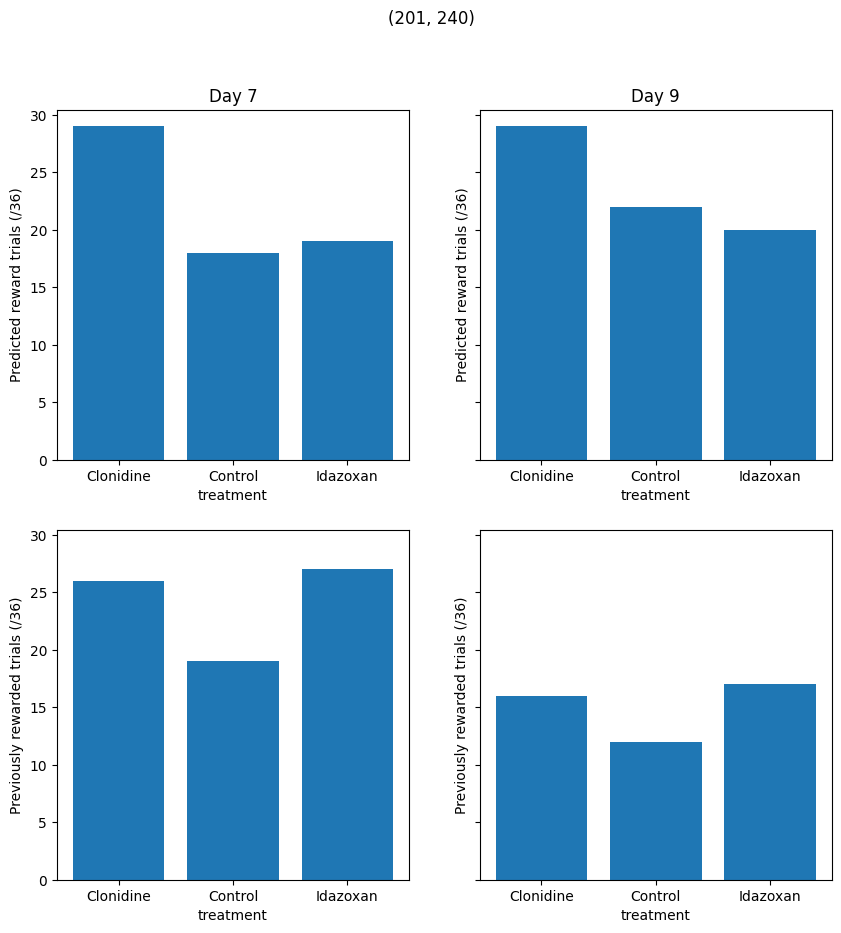

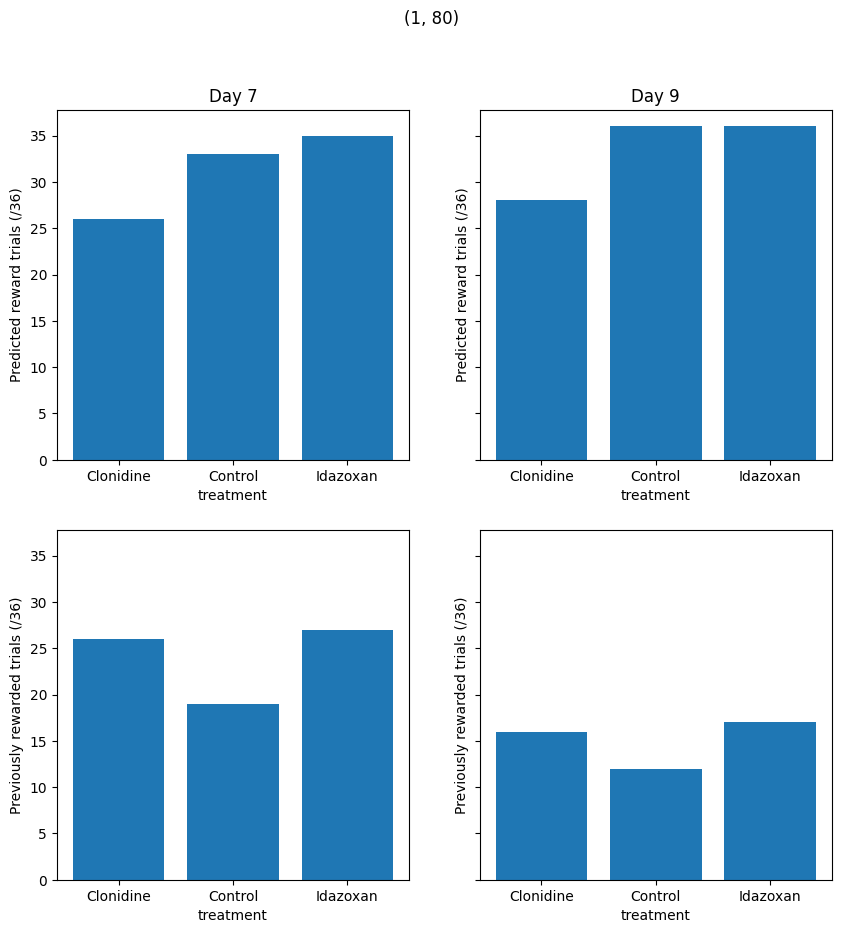

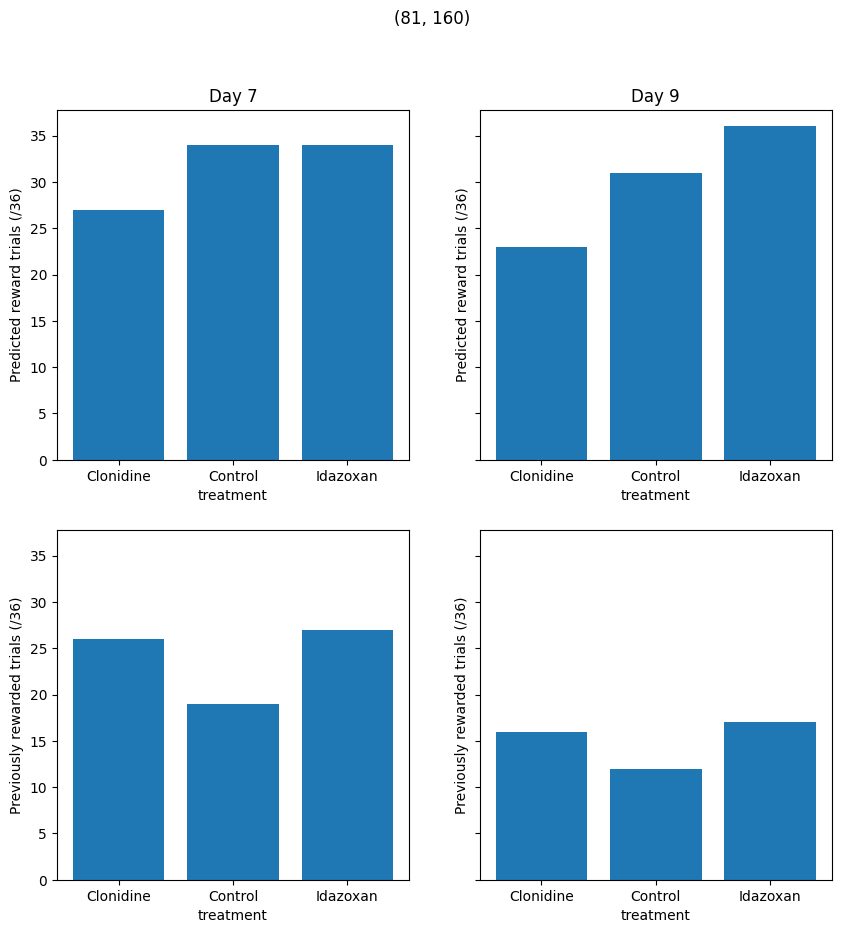

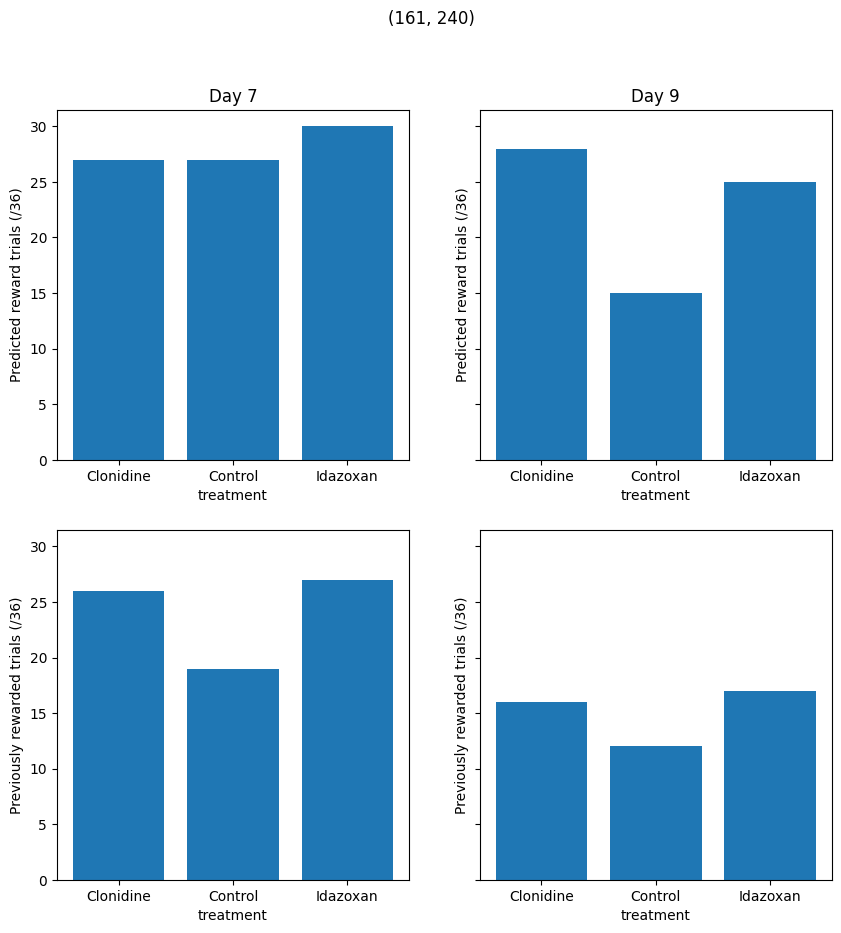

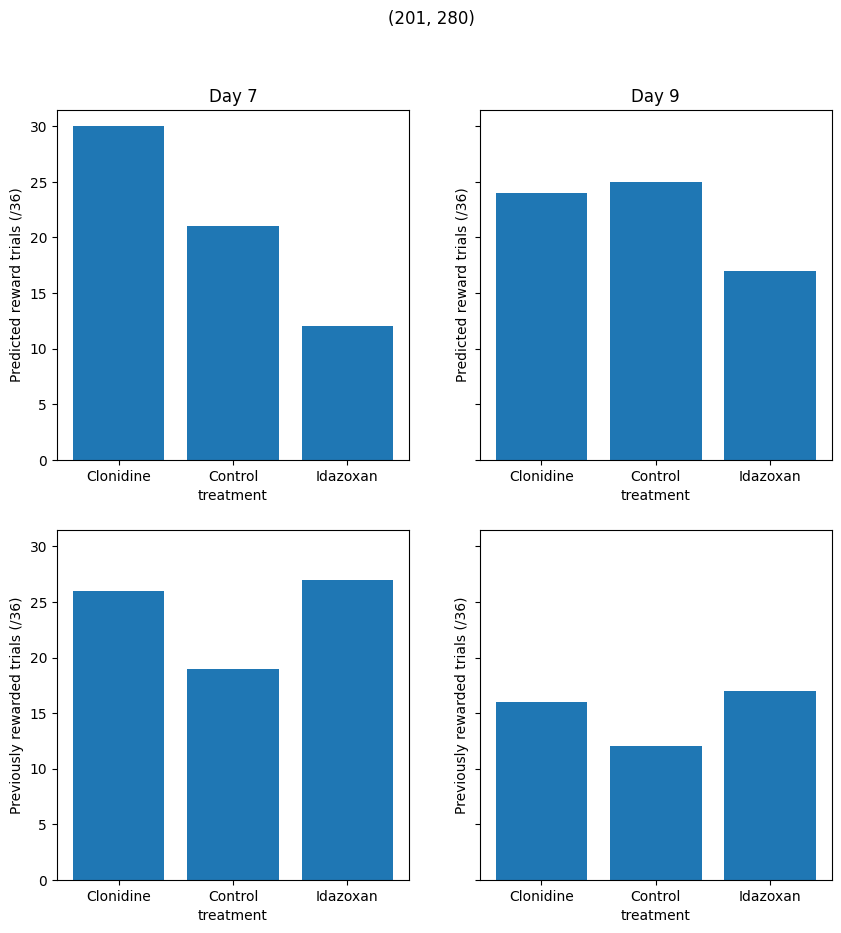

In [64]:
for rd7, rd9 in zip(day7results.keys(), day9results.keys()):
    prediction_counts = present_results(day7results[rd7], day9results[rd9], title = rd7[1])
    test_results_pred_trials, test_results_reward_trials = compute_stats(prediction_counts, title = rd7[1])

In [6]:
#chi2_contingency


In [9]:
prediction_counts

,treatment,Session,Pred_reward_trial,Reward,Previously_rewarded
0,Clonidine,7,29.0,10.0,26.0
1,Clonidine,9,29.0,20.0,16.0
2,Control,7,18.0,17.0,19.0
3,Control,9,22.0,24.0,12.0
4,Idazoxan,7,19.0,9.0,27.0
5,Idazoxan,9,20.0,19.0,17.0


## Summarize results

In [65]:
def summarize_results(results_d7, results_d9, key):
    results = pd.concat([results_d7, results_d9])
    results['Session'] = results['Session_trial'].str.split('_').str[0]
    results['Pred_reward_trial'] = (results['Prop_pred_reward_trial'] > 0.5).astype(float)    
    df = results[['treatment', 'animal', 'val_accuracy', 'test_accuracy']].drop_duplicates()
    df['start_frame'] = key[0]
    df['end_frame'] = key[1]
    return df[['start_frame', 'end_frame', 'val_accuracy', 'test_accuracy']].mean()

In [79]:
#df.to_csv("decoding_summary_results_april19.csv")
df = pd.read_csv("decoding_summary_results_april19.csv", index_col = 0)
df

,start_frame,end_frame,val_accuracy,test_accuracy,pval_val_acc
0,1.0,40.0,0.736353,0.471747,0.22
1,41.0,80.0,0.751994,0.482075,0.12
2,81.0,120.0,0.752236,0.453348,0.14
3,121.0,160.0,0.747920,0.469611,0.46
4,161.0,200.0,0.747066,0.430199,0.44
5,201.0,240.0,0.802422,0.474003,0.02
6,1.0,80.0,0.749719,0.464545,0.44
7,81.0,160.0,0.739627,0.462553,0.46
8,161.0,240.0,0.762947,0.446027,0.10
9,201.0,280.0,0.828368,0.462729,0.02


In [73]:
# df = pd.DataFrame()
# for rd7, rd9 in zip(day7results.keys(), day9results.keys()):
#     df = df.append(summarize_results(day7results[rd7], day9results[rd9], key = rd7[1]), ignore_index=True)

/tmp/ipykernel_198908/3566502465.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(summarize_results(day7results[rd7], day9results[rd9], key = rd7[1]), ignore_index=True)
/tmp/ipykernel_198908/3566502465.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(summarize_results(day7results[rd7], day9results[rd9], key = rd7[1]), ignore_index=True)
/tmp/ipykernel_198908/3566502465.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(summarize_results(day7results[rd7], day9results[rd9], key = rd7[1]), ignore_index=True)
/tmp/ipykernel_198908/3566502465.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

## Overall decoding results

In [74]:
df

,start_frame,end_frame,val_accuracy,test_accuracy,pval_val_acc
0,1.0,40.0,0.736353,0.471747,0.22
1,41.0,80.0,0.751994,0.482075,0.12
2,81.0,120.0,0.752236,0.453348,0.14
3,121.0,160.0,0.747920,0.469611,0.46
4,161.0,200.0,0.747066,0.430199,0.44
5,201.0,240.0,0.802422,0.474003,0.02
6,1.0,80.0,0.749719,0.464545,0.44
7,81.0,160.0,0.739627,0.462553,0.46
8,161.0,240.0,0.762947,0.446027,0.10
9,201.0,280.0,0.828368,0.462729,0.02


/tmp/ipykernel_198908/3555782061.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_198908/3555782061.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()


(201, 240)
Test reward prediction comparisons
                              7         9
(Clonidine, Control)   0.013308  0.119782
(Clonidine, Idazoxan)  0.024449  0.043170
(Control, Idazoxan)    1.000000  0.811070
(201, 240)
Test rewarded trials comparisons
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(201, 280)
Test reward prediction comparisons
                              7         9
(Clonidine, Control)   0.038056  1.000000
(Clonidine, Idazoxan)  0.000048  0.153276
(Control, Idazoxan)    0.058464  0.094264
(201, 280)
Test rewarded trials comparisons
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475


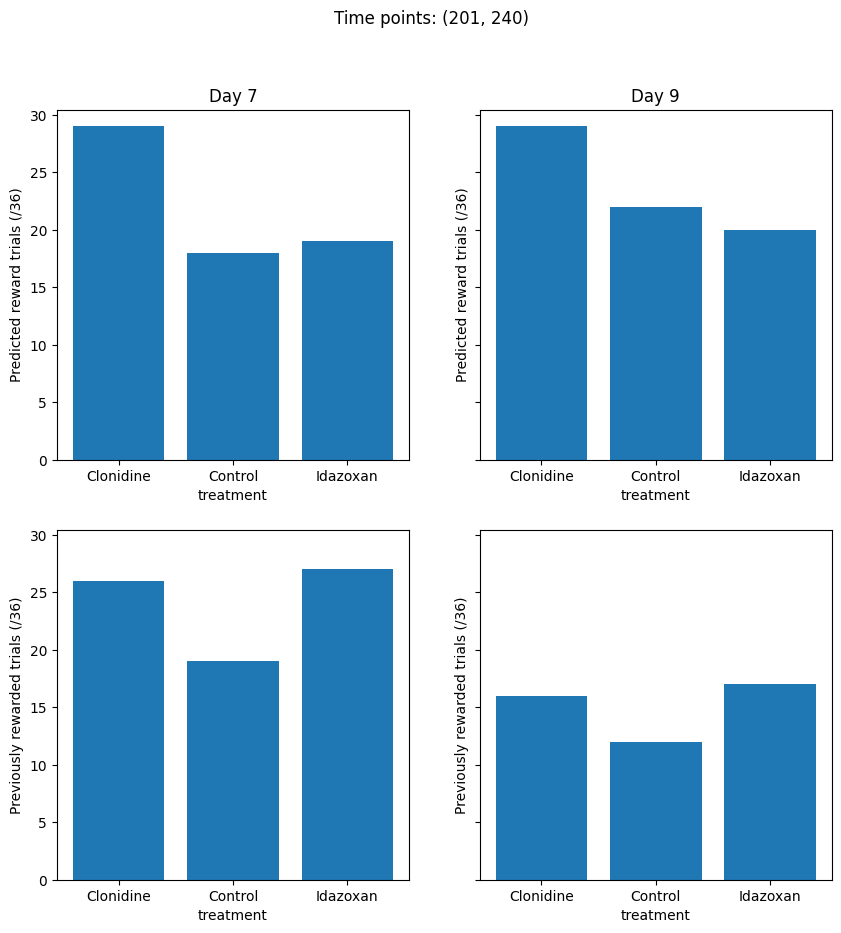

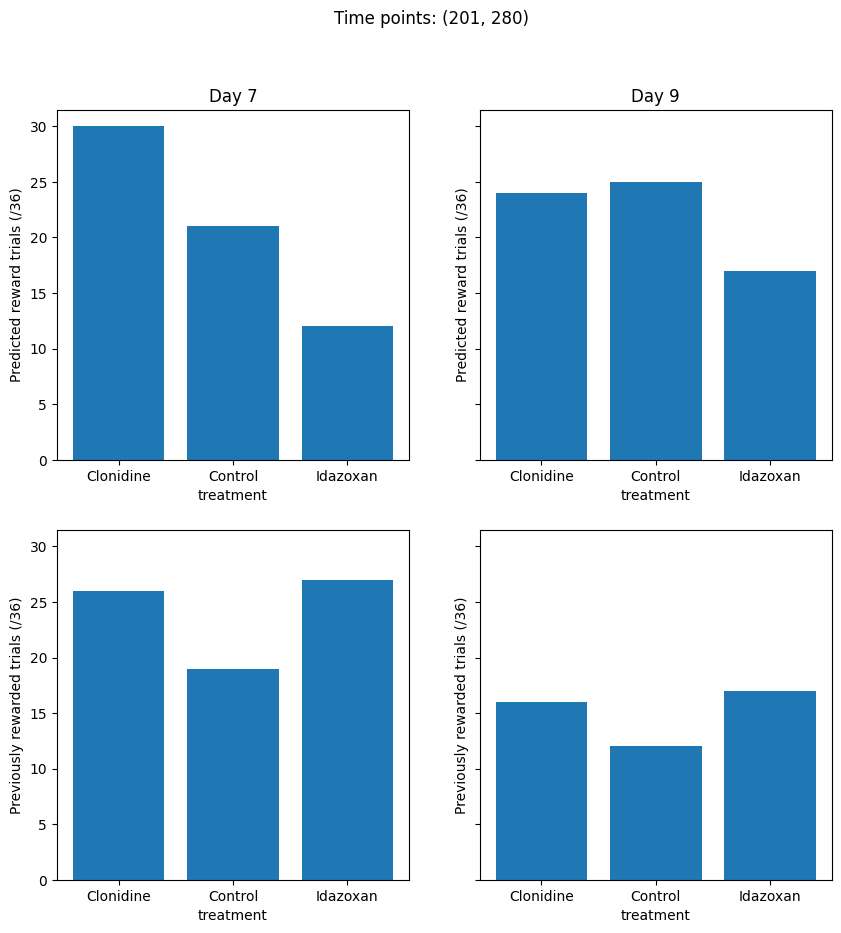

In [83]:
for rd7, rd9 in zip(day7results.keys(), day9results.keys()):
    if rd7[1][0] != 201: continue
    prediction_counts = present_results(day7results[rd7], day9results[rd9], title = rd7[1])
    test_results_pred_trials, test_results_reward_trials = compute_stats(prediction_counts, title = rd7[1])

### Confusion matrices

In [106]:
from scipy.stats import ranksums

,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,test_tp,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session
0,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,0.461538,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7
0,Control,10,0.752821,0.641026,0.825855,0.237179,0.708333,0.416667,0.834262,0.450980,0.147436,0.493590,0.089744,0.269231,0.639957,0.105769,0.185897,0.068376,7
0,Control,M3,0.738462,0.579060,0.916667,0.410256,0.708333,0.416667,0.832347,0.490956,0.202991,0.376068,0.207265,0.213675,0.676282,0.051282,0.240385,0.032051,7
0,Idazoxan,4,0.842051,0.205128,0.914530,0.961538,0.833333,0.166667,0.905868,0.295455,0.166667,0.038462,0.794872,0.000000,0.791667,0.043803,0.122863,0.041667,7
0,Idazoxan,80,0.784615,0.673077,0.881410,0.190171,0.750000,0.333333,0.863130,0.375510,0.098291,0.574786,0.091880,0.235043,0.704060,0.072650,0.177350,0.045940,7
0,Idazoxan,F3,0.860000,0.465812,0.835470,0.284188,0.750000,0.250000,0.912399,0.000000,0.000000,0.465812,0.284188,0.250000,0.723291,0.137821,0.112179,0.026709,7
0,Clonidine,50,0.803077,0.363248,0.723291,0.886752,0.708333,0.250000,0.856716,0.439850,0.250000,0.113248,0.636752,0.000000,0.613248,0.181624,0.110043,0.095085,7
0,Clonidine,83,0.711538,0.365385,0.770299,0.574786,0.750000,0.333333,0.813774,0.301176,0.136752,0.228632,0.438034,0.196581,0.618590,0.098291,0.151709,0.131410,7
0,Clonidine,F4,0.800000,0.250000,1.000000,1.000000,0.791667,0.250000,0.883721,0.400000,0.250000,0.000000,0.750000,0.000000,0.791667,0.000000,0.208333,0.000000,7
0,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,0.271368,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9


In [114]:
rd7 = ("Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=20)),\n                ('lda', LinearDiscriminantAnalysis())])", (201, 240))
rd9 = ("Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=20)),\n                ('lda', LinearDiscriminantAnalysis())])", (201, 240))
results = pd.concat([day7results[rd7], day9results[rd9]])
results['Session'] = results['Session_trial'].str.split('_').str[0]
results['Pred_reward_trial'] = (results['Prop_pred_reward_trial'] > 0.5).astype(float)
results = results.drop(columns = ['Session_trial', 'Reward', 'Prop_pred_reward_trial', 'Pred_reward_trial']).drop_duplicates()
results_mean = results.groupby(['treatment', 'Session']).mean().reset_index()


/tmp/ipykernel_198908/2817624853.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_mean = results.groupby(['treatment', 'Session']).mean().reset_index()


In [113]:
for day in ['7','9']:
    for t1 in results.treatment.unique():
        for t2 in results.treatment.unique():
            if t1 == t2: continue
            resultst1 = results.loc[(results['treatment'] == t1) & (results['Session'] == day), 'test_accuracy']
            resultst2 = results.loc[(results['treatment'] == t2) & (results['Session'] == day), 'test_accuracy']
            pval = ranksums(resultst1, resultst2).pvalue
            print("Day", day, t1, t2, pval)


Day 7 Control Idazoxan 0.5126907602619233
Day 7 Control Clonidine 0.049534613435626706
Day 7 Idazoxan Control 0.5126907602619233
Day 7 Idazoxan Clonidine 0.5126907602619233
Day 7 Clonidine Control 0.049534613435626706
Day 7 Clonidine Idazoxan 0.5126907602619233
Day 9 Control Idazoxan 0.8272593465627113
Day 9 Control Clonidine 0.8272593465627113
Day 9 Idazoxan Control 0.8272593465627113
Day 9 Idazoxan Clonidine 1.0
Day 9 Clonidine Control 0.8272593465627113
Day 9 Clonidine Idazoxan 1.0


In [111]:
resultst1

0    0.354701
0    0.482906
0    0.583333
Name: test_accuracy, dtype: float64

In [95]:
results = pd.concat([day7results[rd7], day9results[rd9]])
results

,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_1,0.0,1.0
1,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_10,0.0,1.0
2,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_11,1.0,1.0
3,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_12,0.0,0.0
4,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_2,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_5,1.0,1.0
8,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_6,0.0,1.0
9,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_7,1.0,1.0
10,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_8,1.0,1.0


In [115]:
results_mean

,treatment,Session,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,test_tp,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn
0,Clonidine,7,0.771538,0.326211,0.831197,0.820513,0.750000,0.277778,0.851404,0.380342,0.212251,0.113960,0.608262,0.065527,0.674501,0.093305,0.156695,0.075499
1,Clonidine,9,0.846410,0.473647,0.833689,0.782764,0.750000,0.555556,0.901122,0.584511,0.405983,0.067664,0.376781,0.149573,0.712963,0.129274,0.120726,0.037037
2,Control,7,0.792821,0.588319,0.834758,0.480769,0.708333,0.472222,0.862222,0.537235,0.270655,0.317664,0.210114,0.201567,0.664174,0.121083,0.170584,0.044160
3,Control,9,0.765470,0.522792,0.832977,0.621083,0.708333,0.666667,0.843404,0.616125,0.405271,0.117521,0.215812,0.261396,0.648504,0.107194,0.184473,0.059829
4,Idazoxan,7,0.828889,0.448006,0.877137,0.478632,0.777778,0.250000,0.893799,0.223655,0.088319,0.359687,0.390313,0.161681,0.739672,0.084758,0.137464,0.038105
5,Idazoxan,9,0.809402,0.485043,0.897080,0.525641,0.777778,0.527778,0.881066,0.408474,0.269231,0.215812,0.256410,0.258547,0.738248,0.063390,0.158832,0.039530
